# Import Libraries

In [1]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

# torch.manual_seed(1)
# if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [3]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [4]:

# # Some settings
# prompt = ["Indian Data scientist working in Bosch"]
# height = 512                        # default height of Stable Diffusion
# width = 512                         # default width of Stable Diffusion
# num_inference_steps = 30            # Number of denoising steps
# guidance_scale = 7.5                # Scale for classifier-free guidance
# generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
# batch_size = 1

# # Prep text
# text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
# with torch.no_grad():
#     text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
# max_length = text_input.input_ids.shape[-1]
# uncond_input = tokenizer(
#     [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
# )
# with torch.no_grad():
#     uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
# text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [5]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

# set_timesteps(scheduler,num_inference_steps)

# # Prep latents
# latents = torch.randn(
#   (batch_size, unet.in_channels, height // 8, width // 8),
#   generator=generator,
# )
# latents = latents.to(torch_device)
# latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# # Loop
# with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
#     for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
#         # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
#         latent_model_input = torch.cat([latents] * 2)
#         sigma = scheduler.sigmas[i]
#         # Scale the latents (preconditioning):
#         # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
#         latent_model_input = scheduler.scale_model_input(latent_model_input, t)

#         # predict the noise residual
#         with torch.no_grad():
#             noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

#         # perform guidance
#         noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#         noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

#         # compute the previous noisy sample x_t -> x_t-1
#         # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
#         latents = scheduler.step(noise_pred, t, latents).prev_sample

# # scale and decode the image latents with vae
# latents = 1 / 0.18215 * latents
# with torch.no_grad():
#     image = vae.decode(latents).sample

# # Display
# image = (image / 2 + 0.5).clamp(0, 1)
# image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
# images = (image * 255).round().astype("uint8")
# pil_images = [Image.fromarray(image) for image in images]
# pil_images[0]

In [6]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images


In [7]:
encoded = torch.rand([1, 4, 64, 64])

In [8]:
encoded.shape

torch.Size([1, 4, 64, 64])

In [9]:
# Settings (same as before except for the new prompt)
# prompt = ["A colorful dancer, nat geo photo indian style"]
# height = 512                        # default height of Stable Diffusion
# width = 512                         # default width of Stable Diffusion
# num_inference_steps = 50            # Number of denoising steps
# guidance_scale = 8                  # Scale for classifier-free guidance
# generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
# batch_size = 1

# # Prep text (same as before)
# text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
# with torch.no_grad():
#     text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
# max_length = text_input.input_ids.shape[-1]
# uncond_input = tokenizer(
#     [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
# )
# with torch.no_grad():
#     uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
# text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# # Prep Scheduler (setting the number of inference steps)
# set_timesteps(scheduler, num_inference_steps)

# # Prep latents (noising appropriately for start_step)
# start_step = 10
# start_sigma = scheduler.sigmas[start_step]
# noise = torch.randn_like(encoded)
# latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
# latents = latents.to(torch_device).float()

# # Loop
# for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
#     if i >= start_step: # << This is the only modification to the loop we do

#         # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
#         latent_model_input = torch.cat([latents] * 2)
#         sigma = scheduler.sigmas[i]
#         latent_model_input = scheduler.scale_model_input(latent_model_input, t)

#         # predict the noise residual
#         with torch.no_grad():
#             noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

#         # perform guidance
#         noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#         noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

#         # compute the previous noisy sample x_t -> x_t-1
#         latents = scheduler.step(noise_pred, t, latents).prev_sample

# latents_to_pil(latents)[0]

In [10]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding


In [11]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

# out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function
# print(out_embs_test.shape) # Check the output shape
# out_embs_test # Inspect the output

In [12]:

def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [13]:

pos_emb_layer = text_encoder.text_model.embeddings.position_embedding

In [14]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

In [15]:
birb_embed = torch.load('learned_embeds_2.bin')
birb_embed.keys(), birb_embed['<buhu>'].shape

(dict_keys(['<buhu>']), torch.Size([1024]))

In [16]:
# birb_embed

torch.Size([1, 77, 768])


<ipython-input-12-3a3228097662>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

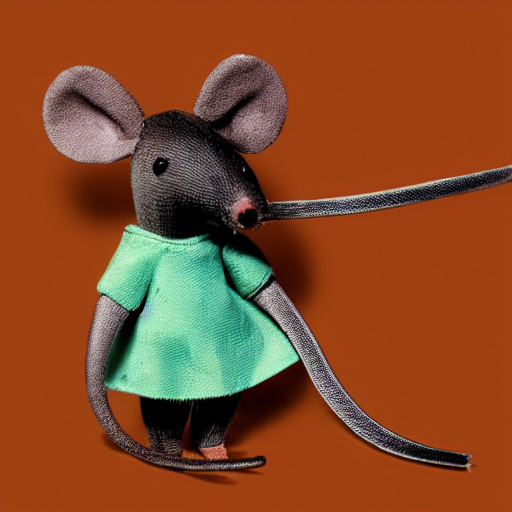

In [17]:
prompt = 'A mouse in the style of puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = birb_embed['<buhu>'][:768].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)
print(token_embeddings.shape)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings)

In [18]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs((images[:,1] - 0.5) + (images[:,0] - 0.5)).mean() # [:,2] -> all images in batch, only the blue channel
    return error


In [19]:
# def generate(prompt):
#   prompt = prompt #@param
#   height = 512                        # default height of Stable Diffusion
#   width = 512                         # default width of Stable Diffusion
#   num_inference_steps = 50  #@param           # Number of denoising steps
#   guidance_scale = 8 #@param               # Scale for classifier-free guidance
#   generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
#   batch_size = 1
#   blue_loss_scale = 200 #@param

#   # Prep text
#   text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
#   with torch.no_grad():
#       text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

#   # And the uncond. input as before:
#   max_length = text_input.input_ids.shape[-1]
#   uncond_input = tokenizer(
#       [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
#   )
#   with torch.no_grad():
#       uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
#   text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#   replacement_token_embedding = birb_embed['<ahx-beta-51c9767>'][:768].to(torch_device)

# # Insert this into the token embeddings
#   token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)
#   # Prep Scheduler
#   set_timesteps(scheduler, num_inference_steps)

#   latents = torch.randn(
#     (batch_size, unet.in_channels, height // 8, width // 8),
#     generator=generator,
#   )
#   latents = latents.to(torch_device)
#   latents = latents * scheduler.init_noise_sigma

#   # Loop
#   for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
#       # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
#       latent_model_input = torch.cat([latents] * 2)
#       sigma = scheduler.sigmas[i]
#       latent_model_input = scheduler.scale_model_input(latent_model_input, t)

#       # predict the noise residual
#       with torch.no_grad():
#           noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

#       # perform CFG
#       noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#       noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

#       if i%5 == 0:
#           # Requires grad on the latents
#           latents = latents.detach().requires_grad_()

#           # Get the predicted x0:
#           # latents_x0 = latents - sigma * noise_pred
#           latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

#           # Decode to image space
#           denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

#           # Calculate loss

#           loss = blue_loss(denoised_images) * blue_loss_scale

#           # Occasionally print it out
#           if i%10==0:
#               print(i, 'loss:', loss.item())

#           # Get gradient
#           cond_grad = torch.autograd.grad(loss, latents)[0]

#           # Modify the latents based on this gradient
#           latents = latents.detach() - cond_grad * sigma**2

#           scheduler._step_index = scheduler._step_index  - 1

#       # Now step with scheduler
#       latents = scheduler.step(noise_pred, t, latents).prev_sample


#   return latents_to_pil(latents)[0]

In [20]:
# latents = torch.randn(
#   (batch_size, unet.in_channels, height // 8, width // 8),
#   generator=generator,
# )
# latents = latents.to(torch_device)
# latents = latents * scheduler.init_noise_sigma

# # Loop
# for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
#     # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
#     latent_model_input = torch.cat([latents] * 2)
#     sigma = scheduler.sigmas[i]
#     latent_model_input = scheduler.scale_model_input(latent_model_input, t)

#     # predict the noise residual
#     with torch.no_grad():
#         noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

#     # perform CFG
#     noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#     noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

#     if i%5 == 0:
#         # Requires grad on the latents
#         latents = latents.detach().requires_grad_()

#         # Get the predicted x0:
#         # latents_x0 = latents - sigma * noise_pred
#         latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

#         # Decode to image space
#         denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

#         # Calculate loss
#         loss = blue_loss(denoised_images) * blue_loss_scale

#         # Occasionally print it out
#         if i%10==0:
#             print(i, 'loss:', loss.item())

#         # Get gradient
#         cond_grad = torch.autograd.grad(loss, latents)[0]

#         # Modify the latents based on this gradient
#         latents = latents.detach() - cond_grad * sigma**2

#         scheduler._step_index = scheduler._step_index  - 1

#     # Now step with scheduler
#     latents = scheduler.step(noise_pred, t, latents).prev_sample


# latents_to_pil(latents)[0]

In [21]:
birb_embed1 = torch.load('learned_embeds_1.bin')
print(birb_embed1.keys(), birb_embed1['<ahx-beta-51c9767>'].shape)
birb_embed2 = torch.load('learned_embeds_2.bin')
print(birb_embed2.keys(), birb_embed2['<buhu>'].shape)
birb_embed3 = torch.load('learned_embeds_3.bin')
print(birb_embed3.keys(), birb_embed3['<finn-token>'].shape)
birb_embed4 = torch.load('learned_embeds_4.bin')
print(birb_embed4.keys(), birb_embed4['<animal-toy>'].shape)
birb_embed5 = torch.load('learned_embeds_5.bin')
print(birb_embed5.keys(), birb_embed5['<sjsu-logo>'].shape)

dict_keys(['<ahx-beta-51c9767>']) torch.Size([1024])
dict_keys(['<buhu>']) torch.Size([1024])
dict_keys(['<finn-token>']) torch.Size([768])
dict_keys(['<animal-toy>']) torch.Size([1024])
dict_keys(['<sjsu-logo>']) torch.Size([1024])


In [22]:
birb_embed5.keys()

dict_keys(['<sjsu-logo>'])

In [23]:
def generate1(prompt):
  prompt = prompt + " in the style of puppy"
  height = 512                        # default height of Stable Diffusion
  width = 512                         # default width of Stable Diffusion
  num_inference_steps = 50
  guidance_scale = 8
  generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
  batch_size = 1
  blue_loss_scale = 200

  # Prep text
  text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  replacement_token_embedding = birb_embed1['<ahx-beta-51c9767>'][:768].to(torch_device)
  # print(text_input)
# Insert this into the token embeddings
  text_input[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)
  with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  # And the uncond. input as before:
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  # print(text_embeddings.shape)

  # Prep Scheduler
  set_timesteps(scheduler, num_inference_steps)

  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.init_noise_sigma

  # Loop
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      # predict the noise residual
      with torch.no_grad():
          noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform CFG
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      if i%5 == 0:
          # Requires grad on the latents
          latents = latents.detach().requires_grad_()

          # Get the predicted x0:
          # latents_x0 = latents - sigma * noise_pred
          latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

          # Decode to image space
          denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
          # print(denoised_images[:,2].shape)
          # Calculate loss
          loss = blue_loss(denoised_images) * blue_loss_scale

          # Occasionally print it out
          if i%10==0:
              print(i, 'loss:', loss.item())

          # Get gradient
          cond_grad = torch.autograd.grad(loss, latents)[0]

          # Modify the latents based on this gradient
          latents = latents.detach() - cond_grad * sigma**2

          scheduler._step_index = scheduler._step_index  - 1

      # Now step with scheduler
      latents = scheduler.step(noise_pred, t, latents).prev_sample


  return latents_to_pil(latents)[0]

In [24]:
def generate2(prompt):
  prompt = prompt + " in the style of puppy"
  height = 512                        # default height of Stable Diffusion
  width = 512                         # default width of Stable Diffusion
  num_inference_steps = 50
  guidance_scale = 8
  generator = torch.manual_seed(42)   # Seed generator to create the inital latent noise
  batch_size = 1
  blue_loss_scale = 200

  # Prep text
  text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  replacement_token_embedding = birb_embed2['<buhu>'][:768].to(torch_device)
  # print(text_input)
# Insert this into the token embeddings
  text_input[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)
  with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  # And the uncond. input as before:
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  # print(text_embeddings.shape)

  # Prep Scheduler
  set_timesteps(scheduler, num_inference_steps)

  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.init_noise_sigma

  # Loop
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      # predict the noise residual
      with torch.no_grad():
          noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform CFG
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      if i%5 == 0:
          # Requires grad on the latents
          latents = latents.detach().requires_grad_()

          # Get the predicted x0:
          # latents_x0 = latents - sigma * noise_pred
          latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

          # Decode to image space
          denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
          # print(denoised_images[:,2].shape)
          # Calculate loss
          loss = blue_loss(denoised_images) * blue_loss_scale

          # Occasionally print it out
          if i%10==0:
              print(i, 'loss:', loss.item())

          # Get gradient
          cond_grad = torch.autograd.grad(loss, latents)[0]

          # Modify the latents based on this gradient
          latents = latents.detach() - cond_grad * sigma**2

          scheduler._step_index = scheduler._step_index  - 1

      # Now step with scheduler
      latents = scheduler.step(noise_pred, t, latents).prev_sample


  return latents_to_pil(latents)[0]

In [25]:
def generate3(prompt):
  prompt = prompt + " in the style of puppy"
  height = 512                        # default height of Stable Diffusion
  width = 512                         # default width of Stable Diffusion
  num_inference_steps = 50
  guidance_scale = 8
  generator = torch.manual_seed(52)   # Seed generator to create the inital latent noise
  batch_size = 1
  blue_loss_scale = 200

  # Prep text
  text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  replacement_token_embedding = birb_embed3['<finn-token>'][:768].to(torch_device)
  # print(text_input)
# Insert this into the token embeddings
  text_input[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)
  with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  # And the uncond. input as before:
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  # print(text_embeddings.shape)

  # Prep Scheduler
  set_timesteps(scheduler, num_inference_steps)

  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.init_noise_sigma

  # Loop
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      # predict the noise residual
      with torch.no_grad():
          noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform CFG
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      if i%5 == 0:
          # Requires grad on the latents
          latents = latents.detach().requires_grad_()

          # Get the predicted x0:
          # latents_x0 = latents - sigma * noise_pred
          latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

          # Decode to image space
          denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
          # print(denoised_images[:,2].shape)
          # Calculate loss
          loss = blue_loss(denoised_images) * blue_loss_scale

          # Occasionally print it out
          if i%10==0:
              print(i, 'loss:', loss.item())

          # Get gradient
          cond_grad = torch.autograd.grad(loss, latents)[0]

          # Modify the latents based on this gradient
          latents = latents.detach() - cond_grad * sigma**2

          scheduler._step_index = scheduler._step_index  - 1

      # Now step with scheduler
      latents = scheduler.step(noise_pred, t, latents).prev_sample


  return latents_to_pil(latents)[0]

In [26]:
def generate4(prompt):
  prompt = prompt + " in the style of puppy"
  height = 512                        # default height of Stable Diffusion
  width = 512                         # default width of Stable Diffusion
  num_inference_steps = 50
  guidance_scale = 8
  generator = torch.manual_seed(62)   # Seed generator to create the inital latent noise
  batch_size = 1
  blue_loss_scale = 200

  # Prep text
  text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  replacement_token_embedding = birb_embed4['<animal-toy>'][:768].to(torch_device)
  # print(text_input)
# Insert this into the token embeddings
  text_input[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)
  with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  # And the uncond. input as before:
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  # print(text_embeddings.shape)

  # Prep Scheduler
  set_timesteps(scheduler, num_inference_steps)

  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.init_noise_sigma

  # Loop
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      # predict the noise residual
      with torch.no_grad():
          noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform CFG
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      if i%5 == 0:
          # Requires grad on the latents
          latents = latents.detach().requires_grad_()

          # Get the predicted x0:
          # latents_x0 = latents - sigma * noise_pred
          latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

          # Decode to image space
          denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
          # print(denoised_images[:,2].shape)
          # Calculate loss
          loss = blue_loss(denoised_images) * blue_loss_scale

          # Occasionally print it out
          if i%10==0:
              print(i, 'loss:', loss.item())

          # Get gradient
          cond_grad = torch.autograd.grad(loss, latents)[0]

          # Modify the latents based on this gradient
          latents = latents.detach() - cond_grad * sigma**2

          scheduler._step_index = scheduler._step_index  - 1

      # Now step with scheduler
      latents = scheduler.step(noise_pred, t, latents).prev_sample


  return latents_to_pil(latents)[0]

In [27]:
def generate5(prompt):
  prompt = prompt + " in the style of puppy"
  height = 512                        # default height of Stable Diffusion
  width = 512                         # default width of Stable Diffusion
  num_inference_steps = 50
  guidance_scale = 8
  generator = torch.manual_seed(72)   # Seed generator to create the inital latent noise
  batch_size = 1
  blue_loss_scale = 200

  # Prep text
  text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  replacement_token_embedding = birb_embed5['<sjsu-logo>'][:768].to(torch_device)
  # print(text_input)
# Insert this into the token embeddings
  text_input[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)
  with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  # And the uncond. input as before:
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  # print(text_embeddings.shape)

  # Prep Scheduler
  set_timesteps(scheduler, num_inference_steps)

  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.init_noise_sigma

  # Loop
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      # predict the noise residual
      with torch.no_grad():
          noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform CFG
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      if i%5 == 0:
          # Requires grad on the latents
          latents = latents.detach().requires_grad_()

          # Get the predicted x0:
          # latents_x0 = latents - sigma * noise_pred
          latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

          # Decode to image space
          denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
          # print(denoised_images[:,2].shape)
          # Calculate loss
          loss = blue_loss(denoised_images) * blue_loss_scale

          # Occasionally print it out
          if i%10==0:
              print(i, 'loss:', loss.item())

          # Get gradient
          cond_grad = torch.autograd.grad(loss, latents)[0]

          # Modify the latents based on this gradient
          latents = latents.detach() - cond_grad * sigma**2

          scheduler._step_index = scheduler._step_index  - 1

      # Now step with scheduler
      latents = scheduler.step(noise_pred, t, latents).prev_sample


  return latents_to_pil(latents)[0]

<ipython-input-23-4842b0cd85df>:34: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 54.99037551879883
10 loss: 161.76455688476562
20 loss: 152.58242797851562
30 loss: 149.0868682861328
40 loss: 148.07276916503906


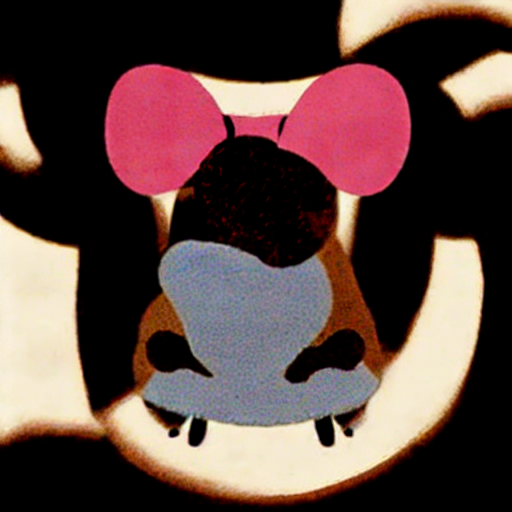

In [28]:
generate1("A mouse like puppy")

<ipython-input-24-372656d840ef>:34: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 58.751441955566406
10 loss: 112.23721313476562
20 loss: 87.06643676757812
30 loss: 80.67292785644531
40 loss: 79.79203796386719


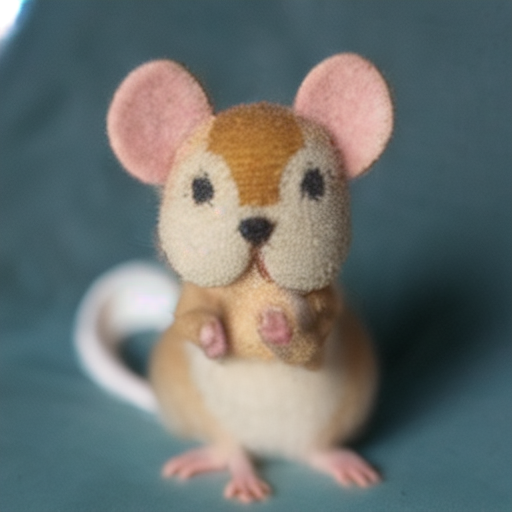

In [29]:
generate2("A mouse like puppy")

<ipython-input-25-61a517e31893>:34: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 68.04004669189453
10 loss: 116.04745483398438
20 loss: 84.82633972167969
30 loss: 81.94100952148438
40 loss: 79.84644317626953


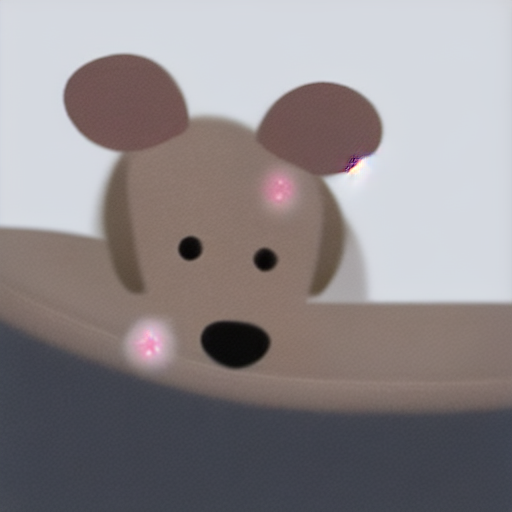

In [30]:
generate3("A mouse like puppy")

<ipython-input-26-ea3a25d88996>:34: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 53.148712158203125
10 loss: 173.8433074951172
20 loss: 161.56668090820312
30 loss: 159.2963409423828
40 loss: 158.98040771484375


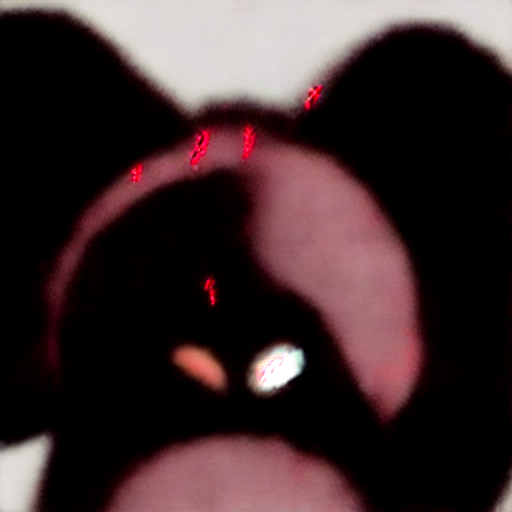

In [31]:
generate4("A mouse like puppy")

<ipython-input-27-e933be19881b>:34: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 50.36252212524414
10 loss: 174.13180541992188
20 loss: 173.73851013183594
30 loss: 166.94158935546875
40 loss: 165.01199340820312


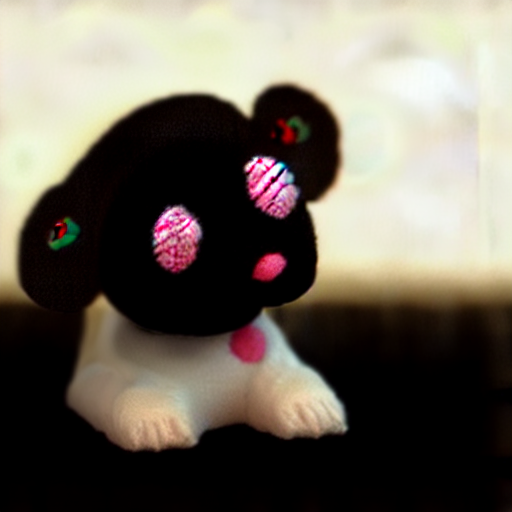

In [38]:
generate5("A mouse like puppy")

In [33]:
!pip install -q gradio

In [39]:
import gradio as gr
from gradio.mix import Parallel, Series

# demo1 = gr.Interface(fn=generate1, inputs="text", outputs="image")
# demo2 = gr.Interface(fn=generate2, inputs="text", outputs="image")
# demo3 = gr.Interface(fn=generate3, inputs="text", outputs="image")
# demo4 = gr.Interface(fn=generate4, inputs="text", outputs="image")
# demo5 = gr.Interface(fn=generate5, inputs="text", outputs="image")

# Series(demo1,demo2,demo3,demo4,demo5).launch()
# demo.launch()
# demo2.launch()

with gr.Blocks() as demo:
  txt = gr.Textbox(label="Input")
  outputs= gr.Image(type="pil")
  btn = gr.Button(value="Style 1 generate")
  btn.click(generate1, inputs=txt, outputs=outputs)

  txt = gr.Textbox(label="Input")
  outputs= gr.Image(type="pil")
  btn = gr.Button(value="Style 2 generate")
  btn.click(generate2, inputs=txt, outputs=outputs)

  txt = gr.Textbox(label="Input")
  outputs= gr.Image(type="pil")
  btn = gr.Button(value="Style 3 generate")
  btn.click(generate3, inputs=txt, outputs=outputs)

  txt = gr.Textbox(label="Input")
  outputs= gr.Image(type="pil")
  btn = gr.Button(value="Style 4 generate")
  btn.click(generate4, inputs=txt, outputs=outputs)

  txt = gr.Textbox(label="Input")
  outputs= gr.Image(type="pil")
  btn = gr.Button(value="Style 5 generate")
  btn.click(generate5, inputs=txt, outputs=outputs)

if __name__ == "__main__":
    demo.launch()






Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5d911dea8dc3da4fcd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [35]:
generate("mouse in a house")

NameError: ignored